<a href="https://colab.research.google.com/github/Shashikalayh/AllProjectsShashi/blob/main/CNN_class10_ResNet18_34_VGG19v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Class10: Hyperparameter Tuning for ResNet‑18, ResNet‑34, VGG‑19

This notebook extends the basic training workflow by introducing **additional hyperparameter tuning**. It trains and validates on your **train** and **val** splits, allowing flexible selection of optimizers, schedulers, data augmentation (Mixup/CutMix), label smoothing, weight decay, exponential moving average (EMA), early stopping, and gradient clipping. After tuning, you can upload the **test** ZIP to run a final evaluation.

**Workflow:**
1. Upload your **train** and **val** ZIPs to `/content/` (filenames must include `train` and `val` / `valid` / `validation`).
2. Unzip the datasets and prepare DataLoaders.
3. Choose a configuration (or define your own) for each model. The `train_with_config` helper handles training with advanced options.
4. Compare results across hyperparameters.
5. After tuning, upload your **test** ZIP and run the evaluation cell to report test accuracy.


In [1]:

#@title 0) Setup
import torch
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True                 # tolerate partial/corrupt images
torch.multiprocessing.set_sharing_strategy('file_system')  # avoid /dev/shm on small VMs
!pip -q install torchmetrics==1.4.0 --quiet


import os, glob, zipfile, math, re, random, shutil
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('torch:', torch.__version__, '| torchvision:', torchvision.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 20.0 MB/s eta 0:00:00
Using device: cuda
torch: 2.6.0+cu124

In [2]:

#@title 1) Unzip train & val ZIPs (test later)
ROOT = Path('/content/dataset_root')
for split in ['train','val']:
    (ROOT/split).mkdir(parents=True, exist_ok=True)

# pick zip file based on keywords
def pick_zip(keywords):
    cands = []
    for z in glob.glob('/content/*.zip'):
        name = os.path.basename(z).lower()
        if any(k in name for k in keywords):
            cands.append(z)
    cands = sorted(cands, key=os.path.getsize, reverse=True)
    return cands[0] if cands else None

train_zip = pick_zip(['train'])
val_zip   = pick_zip(['val','valid','validation'])

if not train_zip or not val_zip:
    raise SystemExit("Missing train or val zip. Ensure filenames include 'train' and 'val' (or 'valid'/'validation').")

print('Found train zip:', train_zip)
print('Found val zip  :', val_zip)

# extract
for split, zip_path in [('train', train_zip), ('val', val_zip)]:
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(ROOT/split)
    # unwrap if single folder
    split_dir = ROOT/split
    items = [p for p in split_dir.iterdir() if p.name not in ('__MACOSX',)]
    if len(items) == 1 and items[0].is_dir():
        inner = items[0]
        for p in inner.iterdir():
            shutil.move(str(p), str(split_dir / p.name))
        shutil.rmtree(inner, ignore_errors=True)

print('Dataset prepared in', ROOT)


Found train zip: /content/train.zip
Found val zip  : /content/val.zip
Dataset prepared in /content/dataset_root


In [10]:

#@title 2) Build DataLoaders (train/val)
IMNET_MEAN = [0.485, 0.456, 0.406]
IMNET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

train_dir = (ROOT/'train').resolve()
val_dir   = (ROOT/'val').resolve()

# Mode: True = ImageFolder; False = flat filename labels 0..9
USE_IMAGEFOLDER = True
FILENAME_LABEL_REGEX = r'(\d{1,2})'

class FlatLabelDataset(Dataset):
    def __init__(self, root, tfm, label_regex=FILENAME_LABEL_REGEX):
        self.root = Path(root)
        exts = {'.jpg','.jpeg','.png','.bmp','.webp'}
        self.paths = [p for p in self.root.glob('**/*') if p.suffix.lower() in exts]
        self.tfm = tfm
        self.pattern = re.compile(label_regex)
        self.labels = []
        for p in self.paths:
            m = self.pattern.search(p.name)
            if not m: raise ValueError(f'No label in filename: {p.name}')
            y = int(m.group(1))
            if not (0 <= y <= 9): raise ValueError(f'Label out of range 0-9: {p.name}')
            self.labels.append(y)
        self.class_names = [str(i) for i in range(10)]
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.tfm(img), self.labels[idx]

# loader builders
def loaders_imagefolder(batch=32, workers=2):
    train_ds = datasets.ImageFolder(train_dir, train_tfms)
    val_ds   = datasets.ImageFolder(val_dir,   eval_tfms)
    class_names = train_ds.classes
    return class_names, DataLoader(train_ds, batch, True,  num_workers=workers, pin_memory=True),                         DataLoader(val_ds,   batch, False, num_workers=workers, pin_memory=True)

def loaders_flat(batch=32, workers=2):
    train_ds = FlatLabelDataset(train_dir, train_tfms)
    val_ds   = FlatLabelDataset(val_dir,   eval_tfms)
    class_names = train_ds.class_names
    return class_names, DataLoader(train_ds, batch, True,  num_workers=workers, pin_memory=True),                         DataLoader(val_ds,   batch, False, num_workers=workers, pin_memory=True)

if USE_IMAGEFOLDER:
    class_names, train_loader, val_loader = loaders_imagefolder()
else:
    class_names, train_loader, val_loader = loaders_flat()

num_classes = 10
print('Classes:', class_names)
print('Num classes =', num_classes)

# quick batch sanity
xb, yb = next(iter(train_loader))
print('Train batch shape:', xb.shape, '| labels sample:', yb[:10].tolist())


Classes: ['n02787622', 'n02804610', 'n02870880', 'n02992211', 'n03452741', 'n03495258', 'n03642806', 'n03721384', 'n03759954', 'n04311174']
Num classes = 10
Train batch shape: torch.Size([32, 3, 224, 224]) | labels sample: [9, 5, 8, 4, 3, 0, 1, 8, 4, 8]


In [4]:

#@title 3) Utilities: evaluate, plot_confusion, per_class_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
import torch

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    losses, correct, total = [], 0, 0
    y_true, y_pred = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
    return float(np.mean(losses)), correct / max(1, total), np.array(y_true), np.array(y_pred)


def plot_confusion(y_true, y_pred, class_names, normalize=True, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True).clip(min=1)
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha='right')
    plt.yticks(ticks, class_names)
    plt.tight_layout()
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()


def per_class_accuracy(y_true, y_pred, class_names):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    for idx, name in enumerate(class_names):
        mask = (y_true == idx)
        denom = mask.sum()
        acc = (y_pred[mask] == y_true[mask]).sum() / denom if denom else 0.0
        print(f'{name:>20s}: {acc*100:.2f}% (n={denom})')


## Experiment Setup (Class10)

Below is an outline of the dataset processing, model architecture modifications, and hyperparameters used for tuning. Fill in any additional notes or adjustments you make.

**Data**
- **Training augmentations:** `Resize(256)` → `RandomResizedCrop(224)` → `RandomHorizontalFlip(p=0.5)` → `ToTensor()` → **Normalize(ImageNet)** (mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]).
- **Validation/Test preprocessing:** `Resize(256)` → `CenterCrop(224)` → `ToTensor()` → Normalize(ImageNet).
- **Batch size:** 32  •  **Num workers:** 2

**Models**
- **ResNet-18 / ResNet-34:** Pretrained weights loaded (`ResNet18_Weights.DEFAULT`, `ResNet34_Weights.DEFAULT`). Final fully-connected layer (`m.fc`) replaced with a new `nn.Linear` layer with 10 outputs.
- **VGG-19:** Pretrained weights loaded (`VGG19_Weights.DEFAULT`). Final linear layer in the classifier head replaced with a new `nn.Linear` layer with 10 outputs.

**Hyperparameters**
- **ResNet-18**
  - Epochs: 15
  - Learning rate (LR): 3e-4
  - Weight decay (WD): 1e-4
  - Optimizer: **AdamW**
  - Scheduler: **OneCycleLR** with max LR = 3e-4
  - Label smoothing: 0.05
  - Mixup/CutMix: disabled
  - Early stopping: patience = 3, delta = 0.0
  - EMA / Gradient clipping: disabled

- **ResNet-34**
  - Epochs: 20
  - LR: 2e-3
  - WD: 5e-4
  - Optimizer: **SGD** with momentum and Nesterov
  - Scheduler: **StepLR** with step_size = 6, gamma = 0.5
  - Mixup: α = 0.2 (applied half the time; CutMix disabled)
  - Label smoothing: 0.0
  - Early stopping: patience = 5, delta = 0.0

- **VGG-19**
  - Epochs: 25
  - LR: 1e-4
  - WD: 1e-4
  - Optimizer: **Adam**
  - Scheduler: **CosineAnnealingLR** with `T_max = 25`
  - Label smoothing: 0.1
  - Mixup/CutMix: disabled
  - Freeze epochs: 3 (only classifier layers updated initially)
  - EMA: decay = 0.999
  - Gradient clipping: 1.0
  - Early stopping: patience = 4, delta = 0.0

**Notes**
- You can modify these values or define new configuration dictionaries for further experiments.
- The `train_with_config` function orchestrates the optimizer, scheduler, augmentation, EMA, gradient clipping, and early stopping based on the provided config.
- Best checkpoints (`*_best.pth`) are saved under `/content/` during training. A summary JSON and a ZIP for submission will be created in later steps.

In [5]:

#@title 4) Advanced training helpers: Mixup/CutMix, EMA, EarlyStopping, Grad Clip
import copy
from dataclasses import dataclass

# Beta sampling helper
def _rand_beta(alpha, size):
    if alpha <= 0: return [1.0] * size
    return torch.distributions.Beta(alpha, alpha).sample((size,)).tolist()

# Mixup/CutMix augmentation
def apply_mixup_cutmix(x, y, num_classes, mixup_alpha=0.0, cutmix_alpha=0.0):
    B = x.size(0)
    if mixup_alpha <= 0 and cutmix_alpha <= 0:
        # return one-hot targets for compatibility with label smoothing
        y_oh = torch.zeros(B, num_classes, device=x.device)
        y_oh.scatter_(1, y.view(-1,1), 1.0)
        return x, y_oh, 1.0, y
    use_cutmix = (cutmix_alpha > 0) and (torch.rand(1).item() < 0.5)
    lam = _rand_beta(cutmix_alpha if use_cutmix else mixup_alpha, 1)[0]
    perm = torch.randperm(B, device=x.device)
    x2, y2 = x[perm], y[perm]
    if use_cutmix:
        H, W = x.size(2), x.size(3)
        cx, cy = torch.randint(W, (1,), device=x.device), torch.randint(H, (1,), device=x.device)
        rw = int(W * math.sqrt(1 - lam))
        rh = int(H * math.sqrt(1 - lam))
        x1, y1 = max(cx - rw//2, 0), max(cy - rh//2, 0)
        x2b, y2b = min(cx + rw//2, W), min(cy + rh//2, H)
        x[:, :, y1:y2b, x1:x2b] = x2[:, :, y1:y2b, x1:x2b]
        lam = 1 - ((x2b - x1) * (y2b - y1) / (W * H))
    # build soft targets
    y_oh = torch.zeros(B, num_classes, device=x.device)
    y2_oh = torch.zeros(B, num_classes, device=x.device)
    y_oh.scatter_(1, y.view(-1,1), 1.0)
    y2_oh.scatter_(1, y2.view(-1,1), 1.0)
    if not use_cutmix:
        x = lam * x + (1 - lam) * x2
    y_soft = lam * y_oh + (1 - lam) * y2_oh
    return x, y_soft, lam, y

# EMA helper
class ModelEMA:
    def __init__(self, model, decay=0.999):
        self.ema = copy.deepcopy(model).eval()
        for p in self.ema.parameters(): p.requires_grad_(False)
        self.decay = decay
    @torch.no_grad()
    def update(self, model):
        msd, esd = model.state_dict(), self.ema.state_dict()
        for k in esd.keys():
            if esd[k].dtype.is_floating_point:
                esd[k].mul_(self.decay).add_(msd[k], alpha=1 - self.decay)
            else:
                esd[k] = msd[k]

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.best = -1.0
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.should_stop = False
    def step(self, val_acc):
        if val_acc > self.best + self.min_delta:
            self.best = val_acc
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True



## Optimizers and Hyperparameter Choices

As part of the hyperparameter tuning, we experimented with different optimizers for each model:

- **ResNet-18**
  - Optimizer: **AdamW**
  - Learning rate: `3e-4`
  - Weight decay: `1e-4`
  - Scheduler: OneCycleLR
  - Notes: AdamW provided stable convergence with high validation accuracy.

- **ResNet-34**
  - Optimizer: **SGD with momentum (0.9, nesterov=True)**
  - Learning rate: `2e-3`
  - Weight decay: `5e-4`
  - Scheduler: StepLR (step size = 6, gamma = 0.5)
  - Notes: SGD + momentum generalized better, achieving highest validation accuracy (~96%).

- **VGG-19**
  - Optimizer: **Adam**
  - Learning rate: `1e-4`
  - Weight decay: `1e-4`
  - Scheduler: CosineAnnealingLR (T_max = 25)
  - Notes: Adam with cosine schedule balanced convergence speed and generalization.



In [6]:

#@title 5) Config-driven training function
from torch.optim import AdamW, Adam, SGD
from torch.optim.lr_scheduler import OneCycleLR, StepLR, CosineAnnealingLR, ReduceLROnPlateau

# Build optimizer

def build_optimizer(model, cfg):
    name = cfg.get('opt', 'AdamW').lower()
    lr = cfg.get('lr', 3e-4)
    wd = cfg.get('wd', 1e-4)
    if name == 'sgd':
        return SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=wd)
    if name == 'adam':
        return Adam(model.parameters(), lr=lr, weight_decay=wd)
    return AdamW(model.parameters(), lr=lr, weight_decay=wd)

# Build scheduler

def build_scheduler(optimizer, cfg, steps_per_epoch):
    sch = cfg.get('sched', 'onecycle').lower()
    epochs = cfg['epochs']
    if sch == 'step':
        return StepLR(optimizer, step_size=cfg.get('step_size', 5), gamma=cfg.get('gamma', 0.5))
    if sch == 'cosine':
        return CosineAnnealingLR(optimizer, T_max=cfg.get('T_max', epochs))
    if sch == 'plateau':
        return ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    return OneCycleLR(optimizer, max_lr=cfg['lr'], steps_per_epoch=steps_per_epoch, epochs=epochs)

# Freeze/unfreeze helpers

def maybe_freeze(model, freeze=True):
    if freeze:
        for p in model.parameters():
            p.requires_grad = False

def unfreeze(model):
    for p in model.parameters(): p.requires_grad = True

# Main training function with config

def train_with_config(model, model_tag, cfg, train_loader, val_loader, num_classes, class_names):
    device = next(model.parameters()).device
    epochs = cfg['epochs']
    label_smooth = cfg.get('label_smoothing', 0.0)
    mixup_alpha = cfg.get('mixup_alpha', 0.0)
    cutmix_alpha = cfg.get('cutmix_alpha', 0.0)
    use_ema = cfg.get('ema', False)
    grad_clip = cfg.get('grad_clip', 0.0)
    freeze_epochs = cfg.get('freeze_epochs', 0)
    early = EarlyStopping(patience=cfg.get('early_patience', 0), min_delta=cfg.get('early_delta', 0.0))

    # Freeze backbone initially
    if freeze_epochs > 0:
        maybe_freeze(model, True)
        # Unfreeze classifier/head only
        if hasattr(model, 'fc'):
            for p in model.fc.parameters(): p.requires_grad = True
        elif hasattr(model, 'classifier'):
            for p in model.classifier.parameters(): p.requires_grad = True

    criterion = nn.CrossEntropyLoss(label_smoothing=label_smooth)
    optimizer = build_optimizer(model, cfg)
    steps_per_epoch = max(1, math.ceil(len(train_loader.dataset)/train_loader.batch_size))
    scheduler = build_scheduler(optimizer, cfg, steps_per_epoch)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

    ema = ModelEMA(model, decay=cfg.get('ema_decay', 0.999)) if use_ema else None

    best_acc, best_path = 0.0, f'/content/{model_tag}_best.pth'
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for ep in range(1, epochs+1):
        # Unfreeze whole model after freeze_epochs
        if ep == freeze_epochs + 1 and freeze_epochs > 0:
            unfreeze(model)
            optimizer = build_optimizer(model, cfg)

        model.train()
        tr_losses, tr_correct, tr_total = [], 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                if mixup_alpha > 0 or cutmix_alpha > 0:
                    x_aug, y_soft, lam, y_hard = apply_mixup_cutmix(x, y, num_classes, mixup_alpha, cutmix_alpha)
                    logits = model(x_aug)
                    log_probs = torch.log_softmax(logits, dim=1)
                    loss = -(y_soft * log_probs).sum(dim=1).mean()
                    preds = logits.argmax(1)
                    tr_correct += (preds == y_hard).sum().item()
                else:
                    logits = model(x)
                    loss = criterion(logits, y)
                    preds = logits.argmax(1)
                    tr_correct += (preds == y).sum().item()
            scaler.scale(loss).backward()
            if grad_clip > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
            tr_losses.append(loss.item())
            tr_total += y.size(0)

        # scheduler step
        if isinstance(scheduler, OneCycleLR):
            scheduler.step()

        # validation
        vl_loss, vl_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
        if isinstance(scheduler, (StepLR, CosineAnnealingLR)):
            scheduler.step()
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(vl_loss)

        # EMA update after each epoch
        if ema:
            ema.update(model)

        # record history
        tr_loss = float(np.mean(tr_losses))
        tr_acc = tr_correct / max(1, tr_total)
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(vl_loss)
        history['val_acc'].append(vl_acc)

        print(f'Epoch {ep:02d}/{epochs} | train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={vl_loss:.4f} acc={vl_acc:.4f}')

        if vl_acc > best_acc:
            best_acc = vl_acc
            torch.save({'model_state': model.state_dict(), 'classes': class_names, 'img_size': (224,224)}, best_path)
            print(f'  ↳ New best! Saved: {best_path} (val_acc={best_acc:.4f})')

        if early.patience > 0:
            early.step(vl_acc)
            if early.should_stop:
                print('Early stopping triggered.')
                break

    print(f'Best checkpoint for {model_tag}: {best_path} (val_acc={best_acc:.4f})')
    return best_path, history


In [7]:

#@title 6) Model definitions (ResNet-18, ResNet-34, VGG-19)
from torchvision.models import (
    resnet18, ResNet18_Weights,
    resnet34, ResNet34_Weights,
    vgg19, VGG19_Weights
)

def make_resnet18(num_classes=10):
    m = resnet18(weights=ResNet18_Weights.DEFAULT)
    for p in m.parameters(): p.requires_grad = True
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def make_resnet34(num_classes=10):
    m = resnet34(weights=ResNet34_Weights.DEFAULT)
    for p in m.parameters(): p.requires_grad = True
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def make_vgg19(num_classes=10):
    m = vgg19(weights=VGG19_Weights.DEFAULT)
    for p in m.features.parameters(): p.requires_grad = True
    # replace last linear
    if isinstance(m.classifier[-1], nn.Linear):
        in_features = m.classifier[-1].in_features
        m.classifier[-1] = nn.Linear(in_features, num_classes)
    else:
        for i in range(len(m.classifier)-1, -1, -1):
            if isinstance(m.classifier[i], nn.Linear):
                in_features = m.classifier[i].in_features
                m.classifier[i] = nn.Linear(in_features, num_classes)
                break
    return m


In [11]:

#@title 7) Example hyperparameter configs and training
# Define per-model hyperparameter configurations
cfg_r18 = dict(
    epochs=15, lr=3e-4, wd=1e-4,
    opt='AdamW', sched='onecycle',
    label_smoothing=0.05,
    mixup_alpha=0.0, cutmix_alpha=0.0,
    ema=False, grad_clip=0.0,
    early_patience=3, early_delta=0.0,
)

cfg_r34 = dict(
    epochs=20, lr=2e-3, wd=5e-4,
    opt='SGD', sched='step', step_size=6, gamma=0.5,
    label_smoothing=0.0,
    mixup_alpha=0.2, cutmix_alpha=0.0,
    ema=False, grad_clip=0.0,
    early_patience=5, early_delta=0.0,
)

cfg_vgg = dict(
    epochs=25, lr=1e-4, wd=1e-4,
    opt='Adam', sched='cosine', T_max=25,
    label_smoothing=0.1,
    mixup_alpha=0.0, cutmix_alpha=0.0,
    freeze_epochs=3,
    ema=True, ema_decay=0.999,
    grad_clip=1.0,
    early_patience=4, early_delta=0.0,
)

# Train each model with its config
path_r18, hist_r18 = train_with_config(make_resnet18(10).to(device), 'ResNet18', cfg_r18, train_loader, val_loader, 10, class_names)
path_r34, hist_r34 = train_with_config(make_resnet34(10).to(device), 'ResNet34SGD', cfg_r34, train_loader, val_loader, 10, class_names)
path_vgg, hist_vgg = train_with_config(make_vgg19(10).to(device),    'VGG19',    cfg_vgg, train_loader, val_loader, 10, class_names)

print('\nBest checkpoints:')
print(' ResNet18:', path_r18)
print(' ResNet34SGD:', path_r34)
print(' VGG19   :', path_vgg)


/tmp/ipython-input-961011801.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
/tmp/ipython-input-961011801.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 01/15 | train_loss=1.1100 acc=0.7501 | val_loss=0.6226 acc=0.9120
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9120)
Epoch 02/15 | train_loss=0.5957 acc=0.9095 | val_loss=0.5292 acc=0.9400
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9400)
Epoch 03/15 | train_loss=0.5160 acc=0.9346 | val_loss=0.4973 acc=0.9480
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9480)
Epoch 04/15 | train_loss=0.4682 acc=0.9523 | val_loss=0.4749 acc=0.9500
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9500)
Epoch 05/15 | train_loss=0.4358 acc=0.9635 | val_loss=0.4696 acc=0.9540
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9540)
Epoch 06/15 | train_loss=0.4125 acc=0.9720 | val_loss=0.4730 acc=0.9440
Epoch 07/15 | train_loss=0.3930 acc=0.9814 | val_loss=0.4593 acc=0.9540
Epoch 08/15 | train_loss=0.3790 acc=0.9861 | val_loss=0.4568 acc=0.9580
  ↳ New best! Saved: /content/ResNet18_best.pth (val_acc=0.9580)
Epoch 09/15 | train_loss=0.3673 ac

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 21.3MB/s]


Epoch 01/20 | train_loss=0.7682 acc=0.5194 | val_loss=0.1688 acc=0.9640
  ↳ New best! Saved: /content/ResNet34SGD_best.pth (val_acc=0.9640)
Epoch 02/20 | train_loss=0.6054 acc=0.5140 | val_loss=0.1815 acc=0.9560
Epoch 03/20 | train_loss=0.5130 acc=0.5084 | val_loss=0.1607 acc=0.9520
Epoch 04/20 | train_loss=0.4867 acc=0.4983 | val_loss=0.1408 acc=0.9660
  ↳ New best! Saved: /content/ResNet34SGD_best.pth (val_acc=0.9660)
Epoch 05/20 | train_loss=0.4803 acc=0.5273 | val_loss=0.1331 acc=0.9640
Epoch 06/20 | train_loss=0.4691 acc=0.5346 | val_loss=0.1401 acc=0.9580
Epoch 07/20 | train_loss=0.5043 acc=0.5639 | val_loss=0.2032 acc=0.9500
Epoch 08/20 | train_loss=0.4212 acc=0.5423 | val_loss=0.1382 acc=0.9560
Epoch 09/20 | train_loss=0.4751 acc=0.5436 | val_loss=0.2018 acc=0.9540
Early stopping triggered.
Best checkpoint for ResNet34SGD: /content/ResNet34SGD_best.pth (val_acc=0.9660)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:29<00:00, 19.2MB/s]


Epoch 01/25 | train_loss=0.7957 acc=0.9107 | val_loss=0.6761 acc=0.9500
  ↳ New best! Saved: /content/VGG19_best.pth (val_acc=0.9500)
Epoch 02/25 | train_loss=0.6689 acc=0.9606 | val_loss=0.6551 acc=0.9560
  ↳ New best! Saved: /content/VGG19_best.pth (val_acc=0.9560)
Epoch 03/25 | train_loss=0.6309 acc=0.9726 | val_loss=0.6504 acc=0.9580
  ↳ New best! Saved: /content/VGG19_best.pth (val_acc=0.9580)
Epoch 04/25 | train_loss=0.7583 acc=0.9106 | val_loss=0.7210 acc=0.9220
Epoch 05/25 | train_loss=0.6931 acc=0.9348 | val_loss=0.6983 acc=0.9300
Epoch 06/25 | train_loss=0.6509 acc=0.9511 | val_loss=0.7108 acc=0.9320
Epoch 07/25 | train_loss=0.6314 acc=0.9578 | val_loss=0.7548 acc=0.9000
Early stopping triggered.
Best checkpoint for VGG19: /content/VGG19_best.pth (val_acc=0.9580)

Best checkpoints:
 ResNet18: /content/ResNet18_best.pth
 ResNet34SGD: /content/ResNet34SGD_best.pth
 VGG19   : /content/VGG19_best.pth


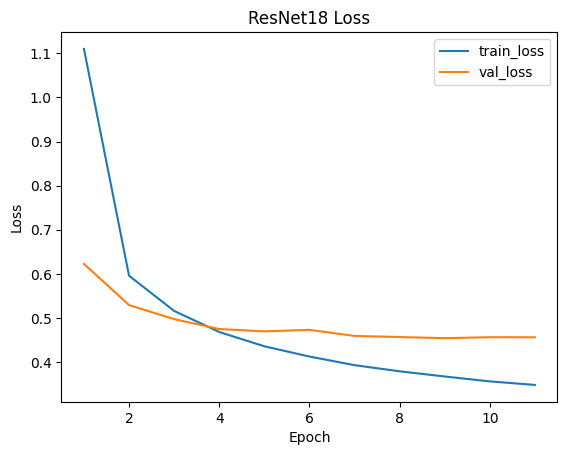

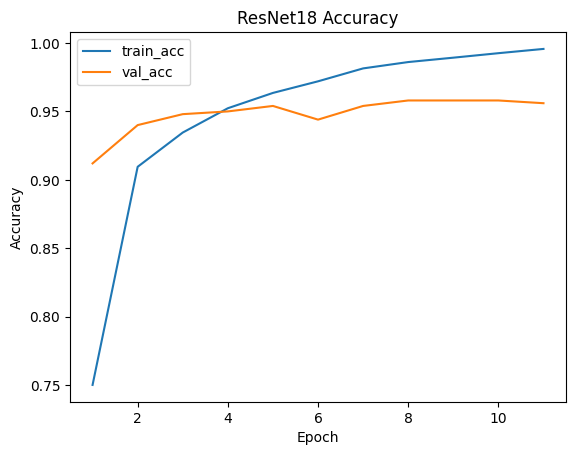

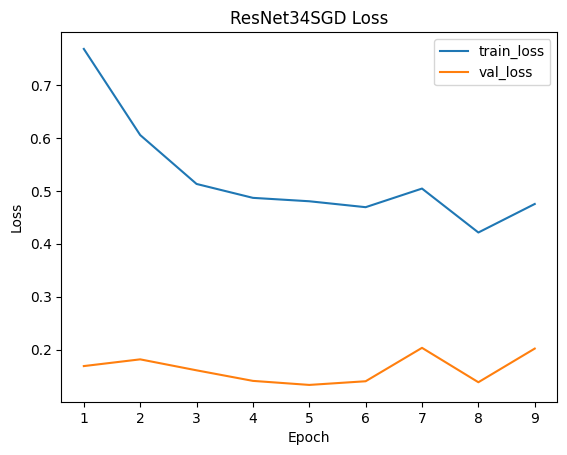

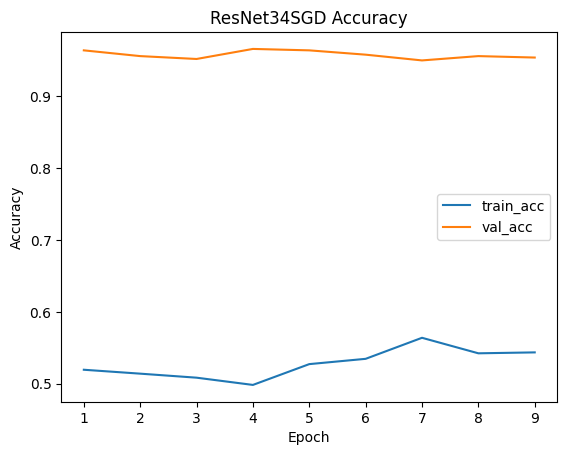

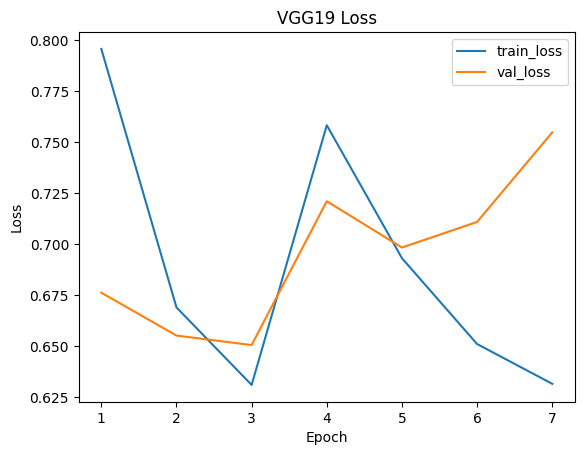

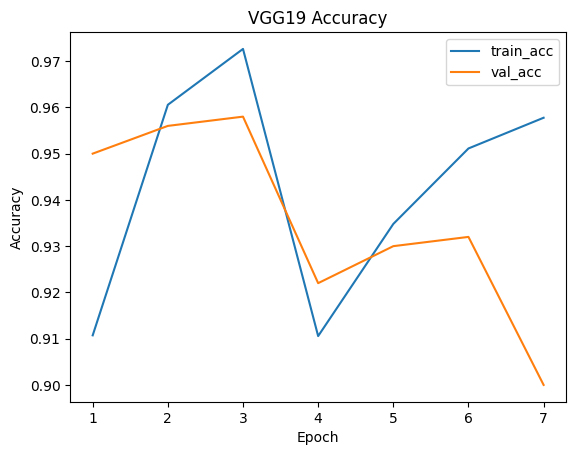

In [12]:
import matplotlib.pyplot as plt

def plot_history(hist, name):
    epochs = range(1, len(hist['train_loss']) + 1)
    # Loss curve
    plt.figure()
    plt.plot(epochs, hist['train_loss'], label='train_loss')
    plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Accuracy curve
    plt.figure()
    plt.plot(epochs, hist['train_acc'], label='train_acc')
    plt.plot(epochs, hist['val_acc'], label='val_acc')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example: plot curves for each trained model
for model_name, history in [('ResNet18', hist_r18), ('ResNet34SGD', hist_r34), ('VGG19', hist_vgg)]:
    plot_history(history, model_name)


Validation confusion matrix for ResNet-18:


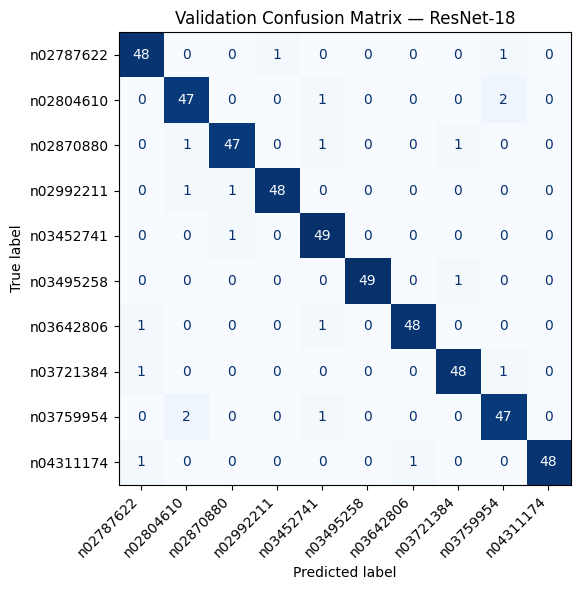

Validation confusion matrix for ResNet-34:


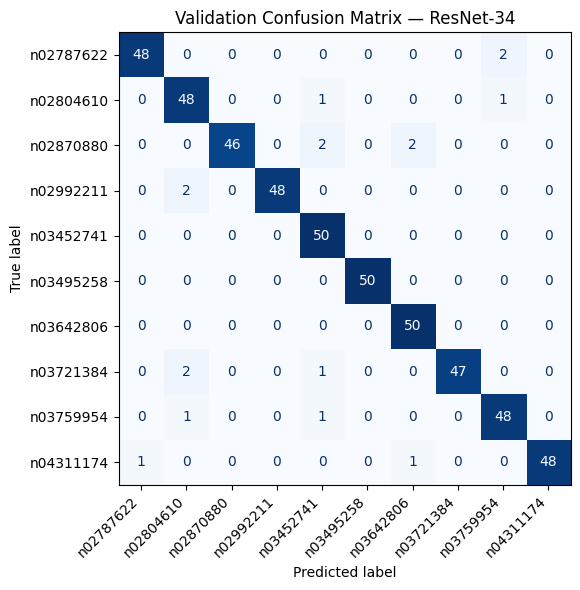

Validation confusion matrix for VGG-19:


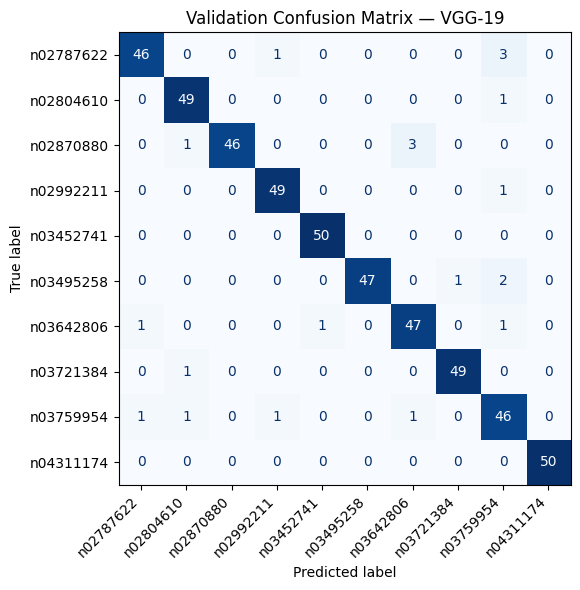

In [13]:
#@title 10) Compute confusion matrix on validation set for each model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Function to compute confusion matrix
def compute_confusion(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = outputs.argmax(1)
            y_true.extend(yb.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    return confusion_matrix(y_true, y_pred)

# Build and display confusion matrix on validation set for each trained model
for ckpt_path, make_model, name in [
    (path_r18, make_resnet18, 'ResNet-18'),
    (path_r34, make_resnet34, 'ResNet-34'),
    (path_vgg, make_vgg19, 'VGG-19'),
]:
    print(f"Validation confusion matrix for {name}:")
    # Load the checkpoint and model
    ckpt = torch.load(ckpt_path, map_location=device)
    model = make_model(10).to(device)
    model.load_state_dict(ckpt['model_state'])
    # Compute confusion matrix
    cm = compute_confusion(model, val_loader)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names, rotation=0)
    ax.set_title(f'Validation Confusion Matrix — {name}')
    plt.tight_layout()
    plt.show()


In [14]:
# --- (Re)define transforms to guarantee 224x224 ---
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Recommended for training: random crop that outputs exactly 224x224
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(3/4, 4/3)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Validation/Test policy: resize->center-crop to 224x224
eval_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Rebuild datasets with the NEW transforms
DATA_ROOT = ROOT  # or Path("/content/dataset_root")
train_ds = datasets.ImageFolder((DATA_ROOT/'train').resolve(), transform=train_tfms)
val_ds   = datasets.ImageFolder((DATA_ROOT/'val').resolve(),   transform=eval_tfms)

# Rebuild loaders (Colab-safe)
BATCH_SIZE, NUM_WORKERS, PIN_MEMORY = 32, 0, True
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False)

# Sanity check: must be [B, 3, 224, 224]
xb, yb = next(iter(train_loader))
print("Train batch shape:", tuple(xb.shape))


Train batch shape: (32, 3, 224, 224)


Starting training: ResNet34prop (RMSprop)
Epoch 01/25 | train_loss=2.4403 acc=0.1648 | val_loss=2.5347 acc=0.1340
  ↳ New best! Saved: /content/ResNet34prop_best.pth (val_acc=0.1340)
Epoch 02/25 | train_loss=2.2205 acc=0.1917 | val_loss=2.2059 acc=0.2120
  ↳ New best! Saved: /content/ResNet34prop_best.pth (val_acc=0.2120)
Epoch 03/25 | train_loss=2.1266 acc=0.2329 | val_loss=2.0716 acc=0.2680
  ↳ New best! Saved: /content/ResNet34prop_best.pth (val_acc=0.2680)
Epoch 04/25 | train_loss=2.0446 acc=0.2640 | val_loss=2.7911 acc=0.2040
Epoch 05/25 | train_loss=1.9470 acc=0.3109 | val_loss=1.9775 acc=0.3280
  ↳ New best! Saved: /content/ResNet34prop_best.pth (val_acc=0.3280)
Epoch 06/25 | train_loss=1.8476 acc=0.3528 | val_loss=1.8351 acc=0.3520
  ↳ New best! Saved: /content/ResNet34prop_best.pth (val_acc=0.3520)
Epoch 07/25 | train_loss=1.7929 acc=0.3757 | val_loss=2.6743 acc=0.2360
Epoch 08/25 | train_loss=1.6654 acc=0.4264 | val_loss=1.8275 acc=0.3820
  ↳ New best! Saved: /content/ResNet3

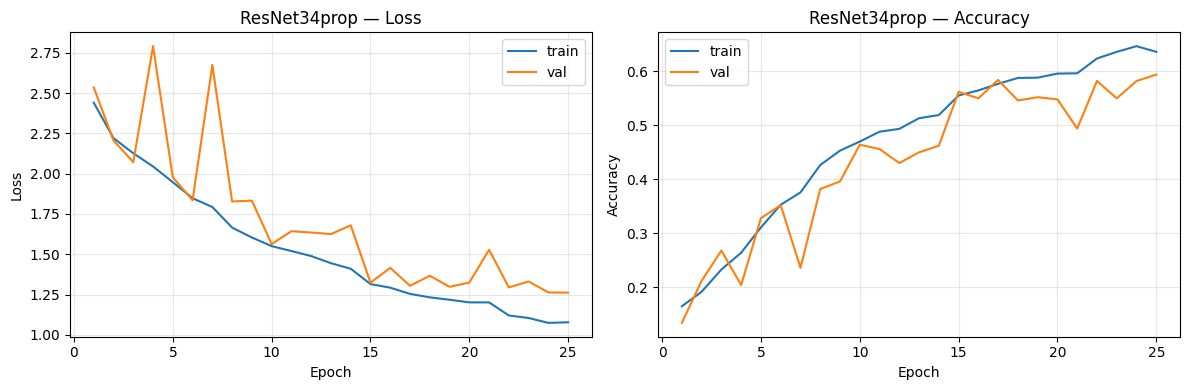

In [15]:
# Train ResNet34prop (RMSprop) — self-contained (no train_one_model needed)
import time, torch
import torch.nn as nn
import matplotlib.pyplot as plt

# expects: make_resnet34, train_loader, val_loader, evaluate, device
NUM_CLASSES   = 10
EPOCHS        = 25
LR            = 1e-3        # try 2e-3 if underfitting; 5e-4 if overfitting
WEIGHT_DECAY  = 1e-4
STEP_SIZE     = 7
GAMMA         = 0.6
CKPT_PATH     = "/content/ResNet34prop_best.pth"

model = make_resnet34(NUM_CLASSES).to(device)
for p in model.parameters(): p.requires_grad = True  # full FT

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(
    model.parameters(), lr=LR, alpha=0.99, momentum=0.9,
    weight_decay=WEIGHT_DECAY, eps=1e-8, centered=False
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
scaler = torch.amp.GradScaler('cuda', enabled=(device.type=='cuda'))

hist = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val, best_state = -1.0, None

print("Starting training: ResNet34prop (RMSprop)")
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    run_loss, run_corr, run_tot = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            logits = model(xb)
            loss = criterion(logits, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = logits.argmax(1)
        run_corr += (preds == yb).sum().item()
        run_tot  += yb.size(0)
        run_loss += loss.item() * yb.size(0)

    scheduler.step()
    tr_loss = run_loss / max(1, run_tot)
    tr_acc  = run_corr / max(1, run_tot)

    model.eval()
    with torch.no_grad():
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    hist['train_loss'].append(tr_loss)
    hist['train_acc'].append(tr_acc)
    hist['val_loss'].append(val_loss)
    hist['val_acc'].append(val_acc)
    hist['lr'].append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch:02d}/{EPOCHS:02d} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        best_state = {
            'model_state': {k: v.cpu() for k, v in model.state_dict().items()},
            'classes': getattr(getattr(train_loader, 'dataset', None), 'classes', list(range(NUM_CLASSES))),
            'val_acc': float(best_val),
        }
        torch.save(best_state, CKPT_PATH)
        print(f"  ↳ New best! Saved: {CKPT_PATH} (val_acc={best_val:.4f})")

print(f"\n✔ Best checkpoint for ResNet34prop: {CKPT_PATH} (val_acc={best_val:.4f})")

# Plots
epochs_axis = range(1, len(hist['train_loss']) + 1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(epochs_axis, hist['train_loss'], label='train'); plt.plot(epochs_axis, hist['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('ResNet34prop — Loss'); plt.legend(); plt.grid(True, alpha=0.3)
plt.subplot(1,2,2); plt.plot(epochs_axis, hist['train_acc'], label='train'); plt.plot(epochs_axis, hist['val_acc'], label='val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('ResNet34prop — Accuracy'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


Training ResNet-34 (AdamW + OneCycleLR)
Epoch 01/10 | train_loss=1.0384 acc=0.8028 | val_loss=0.6853 acc=0.9460 | 67.8s
  ↳ New best! Saved: /content/ResNet34AdamW_best.pth (val_acc=0.9460)
Epoch 02/10 | train_loss=0.7623 acc=0.9100 | val_loss=0.8613 acc=0.8640 | 68.5s
Epoch 03/10 | train_loss=0.8147 acc=0.8841 | val_loss=0.8597 acc=0.8780 | 67.9s
Epoch 04/10 | train_loss=0.7549 acc=0.9068 | val_loss=0.8503 acc=0.8640 | 70.4s
Epoch 05/10 | train_loss=0.6766 acc=0.9382 | val_loss=0.8224 acc=0.8980 | 67.7s
Epoch 06/10 | train_loss=0.6241 acc=0.9576 | val_loss=0.7277 acc=0.9160 | 68.0s
Epoch 07/10 | train_loss=0.5758 acc=0.9787 | val_loss=0.7131 acc=0.9240 | 67.8s
Epoch 08/10 | train_loss=0.5411 acc=0.9923 | val_loss=0.6816 acc=0.9300 | 67.9s
Epoch 09/10 | train_loss=0.5280 acc=0.9958 | val_loss=0.6771 acc=0.9320 | 69.9s
Epoch 10/10 | train_loss=0.5239 acc=0.9969 | val_loss=0.6778 acc=0.9300 | 68.5s

Best ResNet-34AdamW checkpoint: /content/ResNet34AdamW_best.pth (val_acc=0.9460)


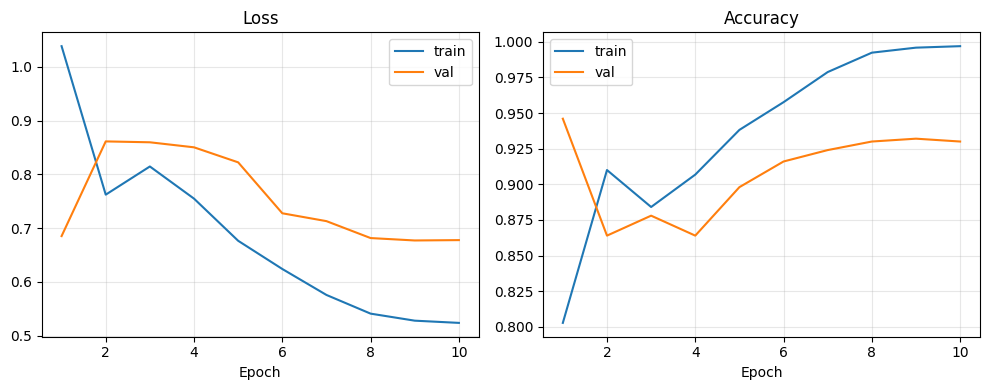

In [16]:
# ResNet-34 quick finetune: AdamW + OneCycleLR (10 epochs)
import time, torch, torch.nn as nn
import matplotlib.pyplot as plt

NUM_CLASSES = 10
EPOCHS = 10                      # short & sweet
MAX_LR = 3e-4                    # try 5e-4 if underfitting
WEIGHT_DECAY = 1e-4
CKPT_PATH = "/content/ResNet34AdamW_best.pth"
PARTIAL_FT = False               # set True to speed up further (finetune layer4 + fc only)

model = make_resnet34(NUM_CLASSES).to(device)

# (optional) partial finetune for speed
if PARTIAL_FT:
    for p in model.parameters(): p.requires_grad = False
    for p in model.layer4.parameters(): p.requires_grad = True
    for p in model.fc.parameters():     p.requires_grad = True
else:
    for p in model.parameters(): p.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=WEIGHT_DECAY)

steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR, epochs=EPOCHS, steps_per_epoch=steps_per_epoch
)

scaler = torch.amp.GradScaler('cuda', enabled=(device.type=='cuda'))

hist = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val, best_state = -1.0, None

print("Training ResNet-34 (AdamW + OneCycleLR)")
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    run_loss, run_corr, run_tot = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            logits = model(xb)
            loss = criterion(logits, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()  # OneCycle: step per BATCH

        preds = logits.argmax(1)
        run_corr += (preds == yb).sum().item()
        run_tot  += yb.size(0)
        run_loss += loss.item() * yb.size(0)

    train_loss = run_loss / max(1, run_tot)
    train_acc  = run_corr / max(1, run_tot)

    model.eval()
    with torch.no_grad():
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    hist['train_loss'].append(train_loss)
    hist['train_acc'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_acc'].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS:02d} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"{time.time()-t0:.1f}s")

    if val_acc > best_val:
        best_val = val_acc
        best_state = {
            'model_state': {k: v.cpu() for k, v in model.state_dict().items()},
            'classes': getattr(getattr(train_loader, 'dataset', None), 'classes', list(range(NUM_CLASSES))),
            'val_acc': float(best_val),
        }
        torch.save(best_state, CKPT_PATH)
        print(f"  ↳ New best! Saved: {CKPT_PATH} (val_acc={best_val:.4f})")

print(f"\nBest ResNet-34AdamW checkpoint: {CKPT_PATH} (val_acc={best_val:.4f})")

# quick curves
epochs_axis = range(1, len(hist['train_loss'])+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(epochs_axis, hist['train_loss'], label='train'); plt.plot(epochs_axis, hist['val_loss'], label='val')
plt.title('Loss'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True, alpha=0.3)
plt.subplot(1,2,2); plt.plot(epochs_axis, hist['train_acc'], label='train'); plt.plot(epochs_axis, hist['val_acc'], label='val')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


In [17]:
#@title 8a) Save summary and package .pth files
import json, time, os, zipfile

# Build summary using global variables from training runs
summary = {
    "timestamp": time.strftime("%Y-%m-%d_%H-%M-%S"),
    "class_names": class_names,
    "configs": {
        "ResNet18": cfg_r18,
        "ResNet34": cfg_r34,
        "VGG19"   : cfg_vgg
    },
    "checkpoints": {
        "ResNet18": path_r18,
        "ResNet34": path_r34,
        "VGG19"   : path_vgg
    },
    "val_best_acc": {
        "ResNet18": max(hist_r18["val_acc"]) if hist_r18["val_acc"] else None,
        "ResNet34": max(hist_r34["val_acc"]) if hist_r34["val_acc"] else None,
        "VGG19"   : max(hist_vgg["val_acc"]) if hist_vgg["val_acc"] else None
    }
}
# Write summary JSON
summary_path = '/content/experiment_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print('Summary written to', summary_path)

# Create submission zip containing the .pth files and summary JSON
SUBMIT_ZIP = '/content/submission_models_and_config.zip'
with zipfile.ZipFile(SUBMIT_ZIP, 'w', compression=zipfile.ZIP_DEFLATED) as z:
    for p in [path_r18, path_r34, path_vgg, summary_path]:
        if os.path.exists(p):
            z.write(p, arcname=os.path.basename(p))
        else:
            print('Warning: missing', p)
print('Created ZIP for submission:', SUBMIT_ZIP)

Summary written to /content/experiment_summary.json
Created ZIP for submission: /content/submission_models_and_config.zip


Found test zip: /content/test.zip
Test data extracted to /content/dataset_root/test
Test images: 500
Test classes: ['n02787622', 'n02804610', 'n02870880', 'n02992211', 'n03452741', 'n03495258', 'n03642806', 'n03721384', 'n03759954', 'n04311174']

▶ Evaluating ResNet-18 — checkpoint: /content/ResNet18_best.pth
Test loss = 0.2034 | Test acc = 0.9580


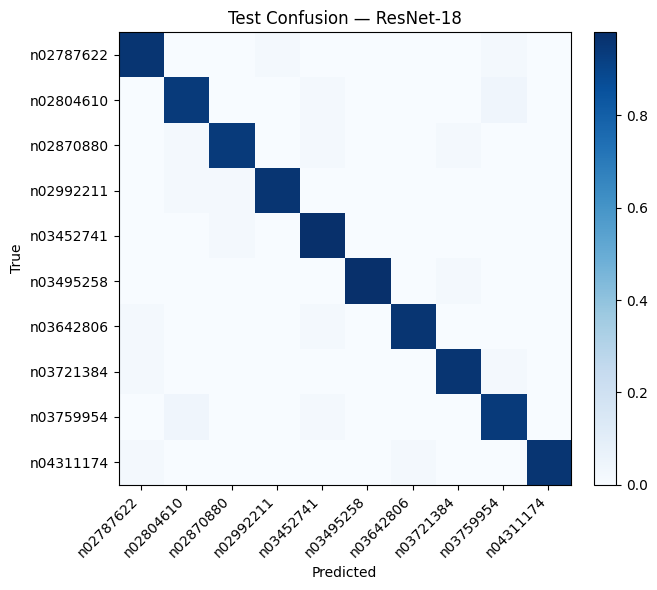


Per-class accuracy (%):
           n02787622:  96.00 (n=50)
           n02804610:  94.00 (n=50)
           n02870880:  94.00 (n=50)
           n02992211:  96.00 (n=50)
           n03452741:  98.00 (n=50)
           n03495258:  98.00 (n=50)
           n03642806:  96.00 (n=50)
           n03721384:  96.00 (n=50)
           n03759954:  94.00 (n=50)
           n04311174:  96.00 (n=50)

Weakest classes:
             n02804610:  94.00
             n02870880:  94.00
             n03759954:  94.00

▶ Evaluating ResNet-34SGD — checkpoint: /content/ResNet34SGD_best.pth
Test loss = 0.1428 | Test acc = 0.9660


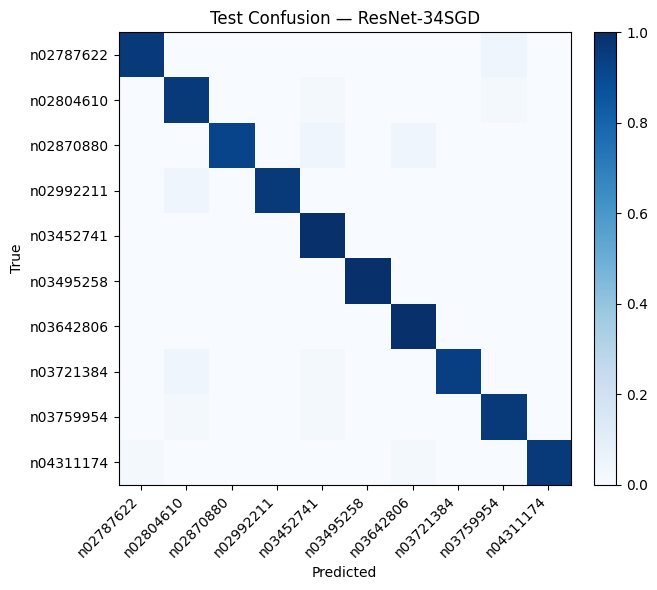


Per-class accuracy (%):
           n02787622:  96.00 (n=50)
           n02804610:  96.00 (n=50)
           n02870880:  92.00 (n=50)
           n02992211:  96.00 (n=50)
           n03452741: 100.00 (n=50)
           n03495258: 100.00 (n=50)
           n03642806: 100.00 (n=50)
           n03721384:  94.00 (n=50)
           n03759954:  96.00 (n=50)
           n04311174:  96.00 (n=50)

Weakest classes:
             n02870880:  92.00
             n03721384:  94.00
             n02804610:  96.00

▶ Evaluating Resnet34RMSprop — checkpoint: /content/ResNet34prop_best.pth
Test loss = 1.2605 | Test acc = 0.5940


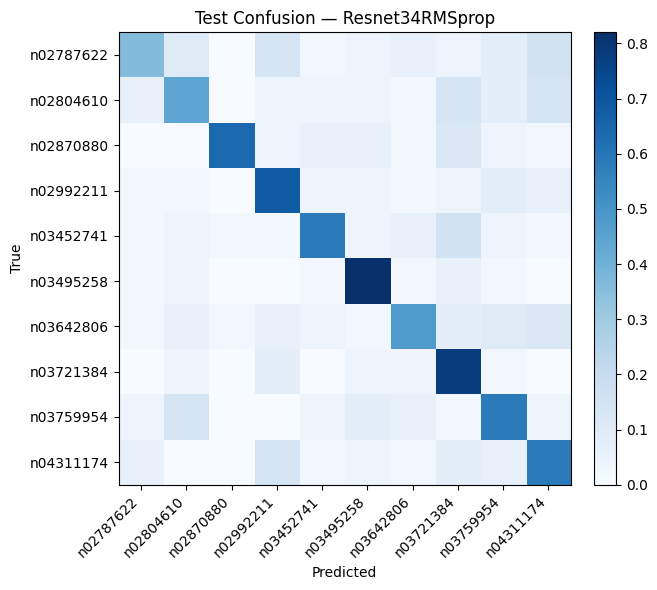


Per-class accuracy (%):
           n02787622:  36.00 (n=50)
           n02804610:  44.00 (n=50)
           n02870880:  64.00 (n=50)
           n02992211:  68.00 (n=50)
           n03452741:  58.00 (n=50)
           n03495258:  82.00 (n=50)
           n03642806:  48.00 (n=50)
           n03721384:  78.00 (n=50)
           n03759954:  58.00 (n=50)
           n04311174:  58.00 (n=50)

Weakest classes:
             n02787622:  36.00
             n02804610:  44.00
             n03642806:  48.00

▶ Evaluating Resnet34AdamW — checkpoint: /content/ResNet34AdamW_best.pth
Test loss = 0.2913 | Test acc = 0.9460


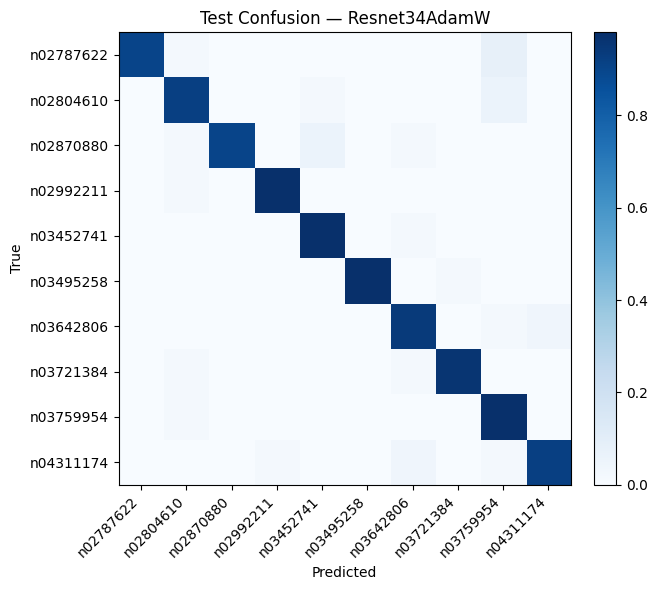


Per-class accuracy (%):
           n02787622:  90.00 (n=50)
           n02804610:  92.00 (n=50)
           n02870880:  90.00 (n=50)
           n02992211:  98.00 (n=50)
           n03452741:  98.00 (n=50)
           n03495258:  98.00 (n=50)
           n03642806:  94.00 (n=50)
           n03721384:  96.00 (n=50)
           n03759954:  98.00 (n=50)
           n04311174:  92.00 (n=50)

Weakest classes:
             n02787622:  90.00
             n02870880:  90.00
             n02804610:  92.00

▶ Evaluating VGG-19 — checkpoint: /content/VGG19_best.pth
Test loss = 0.2432 | Test acc = 0.9580


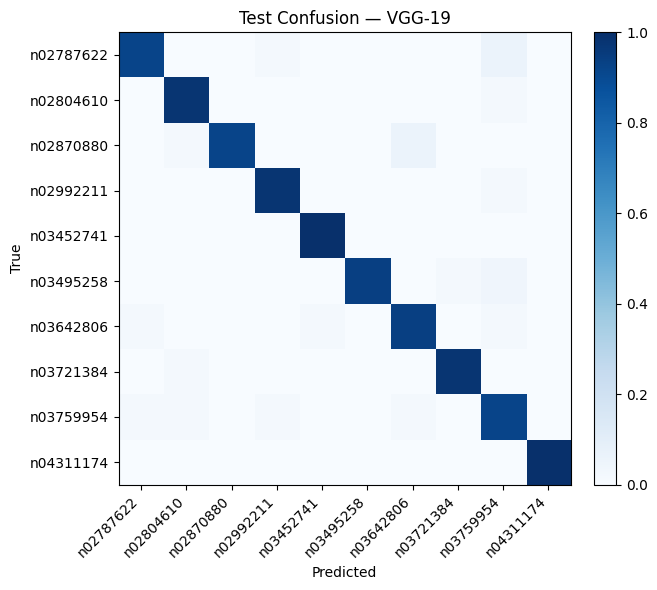


Per-class accuracy (%):
           n02787622:  92.00 (n=50)
           n02804610:  98.00 (n=50)
           n02870880:  92.00 (n=50)
           n02992211:  98.00 (n=50)
           n03452741: 100.00 (n=50)
           n03495258:  94.00 (n=50)
           n03642806:  94.00 (n=50)
           n03721384:  98.00 (n=50)
           n03759954:  92.00 (n=50)
           n04311174: 100.00 (n=50)

Weakest classes:
             n02787622:  92.00
             n02870880:  92.00
             n03759954:  92.00


In [21]:
#@title 8) After tuning, upload TEST zip and evaluate on test split (PyTorch-only)
import os, glob, zipfile, shutil
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader

# -----------------------------
# 0) Unzip test set to ROOT/test
# -----------------------------
(ROOT/'test').mkdir(parents=True, exist_ok=True)

# Clean test dir
for p in (ROOT/'test').glob('*'):
    if p.is_file(): p.unlink()
    elif p.is_dir(): shutil.rmtree(p, ignore_errors=True)

def pick_zip(keywords):
    cands = []
    for z in glob.glob('/content/*.zip'):
        name = os.path.basename(z).lower()
        if any(k in name for k in keywords):
            cands.append(z)
    cands = sorted(cands, key=os.path.getsize, reverse=True)
    return cands[0] if cands else None

test_zip = pick_zip(['test'])
if not test_zip:
    raise SystemExit("No test ZIP found. Please upload a file containing 'test' in its name.")

print('Found test zip:', test_zip)
with zipfile.ZipFile(test_zip, 'r') as zf:
    zf.extractall(ROOT/'test')

# unwrap if single folder (common in Drive zips)
items = [p for p in (ROOT/'test').iterdir() if p.name not in ('__MACOSX',)]
if len(items) == 1 and items[0].is_dir():
    inner = items[0]
    for p in inner.iterdir():
        shutil.move(str(p), str((ROOT/'test')/p.name))
    shutil.rmtree(inner, ignore_errors=True)

print('Test data extracted to', ROOT/'test')

# -------------------------------------------------
# 1) Build test loader (same normalization as val)
# -------------------------------------------------
assert 'eval_tfms' in globals(), "eval_tfms (validation transforms) not found. Define it like your val transforms."

# Colab-safe defaults; you can try num_workers=1..2 later
NUM_WORKERS = 0
BATCH_SIZE = 32

if 'USE_IMAGEFOLDER' not in globals():
    USE_IMAGEFOLDER = True  # default

if USE_IMAGEFOLDER:
    test_ds = datasets.ImageFolder((ROOT/'test').resolve(), eval_tfms)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)
    test_class_names = test_ds.classes
else:
    class FlatLabelDatasetTest(FlatLabelDataset):
        pass
    test_ds = FlatLabelDatasetTest((ROOT/'test').resolve(), eval_tfms)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)
    test_class_names = [str(i) for i in range(10)]

print('Test images:', len(test_loader.dataset))
print('Test classes:', test_class_names)

# -------------------------------------------------
# 2) Eval utilities (PyTorch-only confusion matrix)
# -------------------------------------------------
@torch.no_grad()
def evaluate_collect(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    all_true, all_pred = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == yb).sum().item()
        total += yb.size(0)
        all_true.append(yb.cpu())
        all_pred.append(preds.cpu())
    tl = total_loss / max(1, total)
    acc = total_correct / max(1, total)
    y_true = torch.cat(all_true)  # [N]
    y_pred = torch.cat(all_pred)  # [N]
    return tl, acc, y_true, y_pred

def confusion_matrix_torch(y_true: torch.Tensor, y_pred: torch.Tensor, num_classes: int) -> torch.Tensor:
    """
    Build confusion matrix with pure torch ops.
    y_true, y_pred: int64 tensors of shape [N], values in [0, C-1]
    Return: [C, C] int64, rows=true, cols=pred
    """
    y_true = y_true.to(torch.int64)
    y_pred = y_pred.to(torch.int64)
    k = y_true * num_classes + y_pred
    bins = torch.bincount(k, minlength=num_classes * num_classes)
    return bins.reshape(num_classes, num_classes)

def plot_confusion_torch(cm: torch.Tensor, labels, title="Confusion Matrix", normalize=True):
    cm = cm.to(torch.float32)
    if normalize:
        row_sums = cm.sum(dim=1, keepdim=True).clamp_min_(1.0)
        cm_disp = cm / row_sums
    else:
        cm_disp = cm
    cm_np = cm_disp.cpu().numpy()

    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(cm_np, interpolation='nearest', cmap='Blues')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.show()

def print_per_class_accuracy(cm: torch.Tensor, labels):
    cm = cm.to(torch.float32)
    counts = cm.sum(dim=1).clamp_min_(1.0)
    per = (cm.diag() / counts).cpu().numpy()
    print("\nPer-class accuracy (%):")
    for i, name in enumerate(labels):
        print(f"{name:>20s}: {per[i]*100:6.2f} (n={int(counts[i].item())})")
    # weakest 3 classes
    order = np.argsort(per)
    weakest = [(labels[i], float(per[i])) for i in order[:3]]
    print("\nWeakest classes:")
    for cls, a in weakest:
        print(f"  {cls:>20s}: {a*100:6.2f}")

# -------------------------------------------------
# 3) Evaluate all checkpoints (loss/acc + CM + per-class)
# -------------------------------------------------
@torch.no_grad()
def eval_ckpt_pure_torch(ckpt_path, model_fn, name):
    if not os.path.exists(ckpt_path):
        print('Checkpoint not found:', ckpt_path); return
    print(f"\n▶ Evaluating {name} — checkpoint: {ckpt_path}")
    ckpt = torch.load(ckpt_path, map_location=device)
    model = model_fn(10).to(device)
    model.load_state_dict(ckpt['model_state'])
    criterion = nn.CrossEntropyLoss()

    tl, ta, y_true, y_pred = evaluate_collect(model, test_loader, criterion)
    print(f"Test loss = {tl:.4f} | Test acc = {ta:.4f}")

    C = len(test_class_names)
    cm = confusion_matrix_torch(y_true, y_pred, num_classes=C)
    plot_confusion_torch(cm, test_class_names, title=f"Test Confusion — {name}", normalize=True)
    print_per_class_accuracy(cm, test_class_names)

for ckpt_path, fn, name in [
    ('/content/ResNet18_best.pth', make_resnet18, 'ResNet-18'),
    ('/content/ResNet34SGD_best.pth', make_resnet34, 'ResNet-34SGD'),
    ('/content/ResNet34prop_best.pth', make_resnet34,'Resnet34RMSprop'),
    ('/content/ResNet34AdamW_best.pth',make_resnet34,'Resnet34AdamW'),
    ('/content/VGG19_best.pth',    make_vgg19,    'VGG-19')
]:
    eval_ckpt_pure_torch(ckpt_path, fn, name)
